# Comparing fixed and random orders in performance benchmarking
### Notebook for analysis of performance data collected on the CloudLab for CPU and memory tests

--------------
## **To run this notebook using Google Colab**:
1. `File -> Save a copy in Drive`
2. If you aren't logged into a Google account, a pop-up window will say: "Google sign-in required". Cick "Sign in" and proceed with an account of your choice; if you don't have a Google account, you will have to create one, and that option will be offered after clicking "Sign in".
3. Once logged in, you should see your own copy of this notebook (it will be saved in your account's Google Drive). `Runtime -> Run all` is the simplest way to 
run all code. You might see a warning pop up: "Warning: This notebook was not authored by Google"; click "Run anyway" to proceed.
4. To make sure that the code is running, scroll down and see the outputs undeneath the cells as they appear while the code is running. Running the entire notebook should take around `10 minutes` (fetching the data from a Zenodo repository might be the slowest part of the entire process).
--------------

Contributors:

- Dmitry Duplyakin (University of Utah)
- Nikhil Ramesh (University of Utah) 
- Carina Imburgia (University of Washington) 
- Hamza Fathallah Al Sheikh (University of Utah) 
- Semil Jain (University of Utah) 
- Prikshit Tekta (University of Utah) 
- Aleksander Maricq (University of Utah) 
- Gary Wong (University of Utah) 
- Robert Ricci (University of Utah) 

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statistics as stat
import seaborn as sns

# Improve plot quality 
%config InlineBackend.figure_format = 'retina'

# Convenience functions

def epoch2human(epoch):
  return dt.datetime.fromtimestamp(epoch).strftime('%Y-%m-%d %H:%M:%S')

# For CPU data preprocessing: check if multithreading was used or not
def cpu_multithreading_check(row):
  if(row['total_threads']!=1):
    return 1
  else:
    return 0

# For Memory data preprocessing: check if multithreading was used or not
def mem_multithreading_check(row):
  if("omp" in row["testname"]):
    return 1
  else:
    return 0

def SW_test(df, measure, columns):

  # Defines a dataframe for pvalues and config information along with number of datapoints per config 
  df_cols = ['S-W Test', 'length'] + columns 
  shapiro_wilk = pd.DataFrame(columns=df_cols) 

  for key, grp in df.groupby(columns):
      shapiro_wilk.loc[len(shapiro_wilk)] = [stats.shapiro(grp[measure])[1], len(grp)]+ list(key) 
  
  not_normal = shapiro_wilk[shapiro_wilk["S-W Test"]<0.05]
  num_config_not_normal = len(not_normal)
  num_config_normal = len(shapiro_wilk)-len(not_normal)
  fraction_not_normal = len(not_normal)/len(shapiro_wilk)
  shapiro_stats = [num_config_not_normal, num_config_normal, fraction_not_normal]
  
  return shapiro_wilk, shapiro_stats

def percent_difference(v_experiment,v_control):
  return ((v_experiment.mean() - v_control.mean()) / v_control.mean()) * 100

def effect_size_eta_squared_KW(v_experiment, v_control):
  """
  Returns the ets_sqared measure for effect size calculated for the KW test
  For details see: http://www.tss.awf.poznan.pl/files/3_Trends_Vol21_2014__no1_20.pdf
  (Chose eta_squared over the epsilon squared since it is the more popular method) 
  """
  H = stats.kruskal(v_experiment,v_control)[0]
  k = 1
  n = len(v_experiment) + len(v_control)
  return ((H-k + 1)/(n-k))

def calc_main(df,measure):

  configuration_key = ["hw_type", "testname", "dvfs", "socket_num","MT"]
  df_effect = pd.DataFrame(columns = configuration_key + \
                           ["P_Diff","effect_size_KW", "Kruskal_p"])

  for idx, grp in df.groupby(configuration_key):
    random_sample = grp[grp.random == 1][measure].values
    random_sample = random_sample.astype(np.float64)
    fixed_sample = grp[grp.random == 0][measure].values 
    fixed_sample = fixed_sample.astype(np.float64)
    df_effect.loc[len(df_effect)] = list(idx) + \
      [percent_difference(random_sample, fixed_sample), \
       effect_size_eta_squared_KW(random_sample, fixed_sample), \
       stats.kruskal(random_sample, fixed_sample)[1]]
  
  return df_effect

def p2posneg(row):
  if(row["P_Diff"]>0):
    return "positive"
  else:
    return "negative"

def ci(s,  alpha=0.95, p=0.50, n_thresh=10):
    """ 
    For values in the given array s and p in [0, 1], this fuction returns 
    empirical p-quantile value and its nonparametric 95% confidence interval.
    Refer to book by Boudec: https://infoscience.epfl.ch/record/146812/files/perfPublisherVersion_1.pdf,
    (Page 36 describes how nonparametric confidence intervals can be obtained for p-quantiles)
    """
    n = len(s)
    q = np.quantile(s, p)
    eta = stats.norm.ppf((1+alpha)/2.0) # 1.96 for alpha = 0.95
    lo_rank = max(int(np.floor(n * p - eta * np.sqrt(n * p * (1-p)))), 0)
    hi_rank = min(int(np.ceil(n * p + eta * np.sqrt(n * p * (1-p))) + 1), n-1)
    s_sorted = sorted(s.tolist())
    q_ci_lo = s_sorted[lo_rank]
    q_ci_hi = s_sorted[hi_rank]
    return q, q_ci_lo, q_ci_hi

def CI_compare_fixed_and_random(datf,measure,alpha = 0.95,p = 0.5):
  df = pd.DataFrame(columns=["hw_type", "testname", "dvfs", "socket_num","MT","random","pth_quantile","low","high"])
  for idx,grp in datf.groupby(["hw_type", "testname", "dvfs", "socket_num","MT","random"]):
    m,lo,hi = ci(grp[measure].values, alpha=alpha, p=p)
    df.loc[len(df)] = list(idx) + [m,lo,hi]
  return df

def CI_count_cases(df):
  fin_df = pd.DataFrame(columns=["hw_type", "testname", "dvfs", "socket_num","MT", "Case", "Inner_diff"])
  for idx,grp in df.groupby(["hw_type", "testname", "dvfs", "socket_num","MT"]):
    rand = grp[grp["random"] == 1]
    seq = grp[grp["random"] == 0]
    rand_pq = rand["pth_quantile"].values[0]
    rand_high = rand["high"].values[0] 
    rand_low = rand["low"].values[0] 
    seq_pq = seq["pth_quantile"].values[0]
    seq_high = seq["high"].values[0] 
    seq_low = seq["low"].values[0] 

    ##Calculating the differences
    if(rand_high>seq_high):
      ch = rand_low - seq_high
      if(ch < 0): #Case 2 or Case 3
        ch = None

    else:
      ch = seq_low - rand_high
      if(ch < 0):
        ch = None
    
    #case 1 no overlap
    if(rand_low > seq_high or seq_low> rand_high): # make this else 
      fin_df.loc[len(fin_df)] = list(idx) + ["Case 1", ch]
    
    #case 2 and 3 checking for overlap
    elif((seq_high >= rand_low and rand_high >= seq_high) or (rand_high >= seq_low and seq_high >= rand_high)):
      #case 2 checking if medians overlap
      if((rand_high>= seq_high and (seq_pq >= rand_low or rand_pq <= seq_high)) or (seq_high >= rand_high and (rand_pq >= seq_low or seq_pq <= rand_high))):
        fin_df.loc[len(fin_df)] = list(idx) + ["Case 2", ch]
      else: # case 3 no median overlap but overlap of CI present
        fin_df.loc[len(fin_df)] = list(idx) + ["Case 3", ch]
    else:
      fin_df.loc[len(fin_df)] = list(idx) + ["Potential error", ch]
  
  return fin_df

def CI_plot_cases(data):
  fig, (ax) = plt.subplots(1, 1, figsize=(6,4))
  ax.bar(x = [1,3,5], height=data, tick_label= ["case1", "case2","case3"])
  ax.set_title("Histogram of the split between the cases")
  ax.set_xlabel("Case type")
  ax.set_ylabel("Number of configuration of the case type")

In [2]:
# Fetch data from Zenodo repo
import requests
tar_url = "https://zenodo.org/record/7903144/files/cloudlab-longterm-dataset.tar.gz?download=1"
r = requests.get(tar_url)
with open("cloudlab-longterm-dataset.tar.gz",'wb') as f:
    f.write(r.content)

# Extract downloaded archive
!tar xzvf cloudlab-longterm-dataset.tar.gz

./._cpu_fixed.csv
./cpu_fixed.csv
./._cpu_rand.csv
./cpu_rand.csv
./._memory_fixed.csv
./memory_fixed.csv
./._memory_rand.csv
./memory_rand.csv


In [3]:
# Load csv into dataframes
cpu_fixed = pd.read_csv("cpu_fixed.csv")
cpu_rand = pd.read_csv("cpu_rand.csv")
mem_fixed = pd.read_csv("memory_fixed.csv")
mem_rand = pd.read_csv("memory_rand.csv")

In [4]:
# Print time ranges for 4 subsets of data

print("CPU fixed tests, time range: ", \
      epoch2human(min(cpu_fixed["timestamp"].values)), " - ", \
      epoch2human(max(cpu_fixed["timestamp"].values)))
print("CPU random tests, time range: ", \
      epoch2human(min(cpu_rand["timestamp"].values)), " - ", \
      epoch2human(max(cpu_rand["timestamp"].values)))

print("Memory fixed tests, time range: ", \
      epoch2human(min(mem_fixed["timestamp"].values)), " - ", \
      epoch2human(max(mem_fixed["timestamp"].values)))
print("Memory random tests, time range: ", \
      epoch2human(min(mem_rand["timestamp"].values)), " - ", \
      epoch2human(max(mem_rand["timestamp"].values)))

CPU fixed tests, time range:  2020-06-11 00:21:40  -  2021-03-09 01:49:57
CPU random tests, time range:  2020-06-11 18:18:48  -  2021-03-09 02:02:16
Memory fixed tests, time range:  2020-06-11 00:21:40  -  2021-03-09 01:49:57
Memory random tests, time range:  2020-06-11 18:18:48  -  2021-03-09 14:00:39


In [5]:
# Data preprocessing

cpu_fixed['nthreads'] = cpu_fixed['nthreads'].apply(pd.to_numeric, errors='ignore')
cpu_fixed['MT'] = cpu_fixed.apply(lambda row: cpu_multithreading_check(row), axis=1)
cpu_rand['nthreads'] = cpu_rand['nthreads'].apply(pd.to_numeric, errors='ignore')
cpu_rand['MT'] = cpu_rand.apply(lambda row: cpu_multithreading_check(row), axis=1)
mem_fixed['nthreads'] = mem_fixed['nthreads'].apply(pd.to_numeric, errors='ignore')
mem_fixed['MT'] = mem_fixed.apply(lambda row: mem_multithreading_check(row), axis=1)
mem_rand['nthreads'] = mem_rand['nthreads'].apply(pd.to_numeric, errors='ignore')
mem_rand['MT'] = mem_rand.apply(lambda row: mem_multithreading_check(row), axis=1)

In [6]:
# Combine dataframes

cpu_all = pd.concat([cpu_rand, cpu_fixed])
mem_all = pd.concat([mem_rand, mem_fixed])

print("# of CPU measurements:", len(cpu_all))
print("# of memory measurements:", len(mem_all))
print("Total # of performance measurements:", len(cpu_all) + len(mem_all))

# of CPU measurements: 838157
# of memory measurements: 1456970
Total # of performance measurements: 2295127


In [7]:
# Testing with Shapiro-Wilk

print("-- Memory fixed tests -- ")
mem_shapiro_wilk_fixed, shapiro_stats = SW_test(mem_fixed, "mean", ["hw_type", "testname", "dvfs", "socket_num","MT"])
print("Number of configurations not normally distributed", shapiro_stats[0])
print("Number of configurations normally distributed", shapiro_stats[1])
print("Fraction of configurations not normally distributed", shapiro_stats[2])

print("-- Memory random tests -- ")
mem_shapiro_wilk_rand, shapiro_stats = SW_test(mem_rand, "mean", ["hw_type", "testname", "dvfs", "socket_num","MT"])
print("Number of configurations not normally distributed", shapiro_stats[0])
print("Number of configurations normally distributed", shapiro_stats[1])
print("Fraction of configurations not normally distributed", shapiro_stats[2])

print("-- CPU fixed tests -- ")
cpu_shapiro_wilk_fixed, shapiro_stats_cpu_f = SW_test(cpu_fixed, "exec_time", ["hw_type", "testname", "dvfs", "socket_num","MT"])
normally_distributed_seq = cpu_shapiro_wilk_fixed[cpu_shapiro_wilk_fixed["S-W Test"]>0.05]
display(normally_distributed_seq)
print("Number of configurations not normally distributed", shapiro_stats_cpu_f[0])
print("Number of configurations normally distributed", shapiro_stats_cpu_f[1])
print("Fraction of configurations not normally distributed", shapiro_stats_cpu_f[2])

print("-- CPU random tests -- ")
cpu_shapiro_wilk_rand, shapiro_stats_cpu_r = SW_test(cpu_rand,"exec_time",["hw_type", "testname", "dvfs", "socket_num","MT"])
normally_distributed_rand = cpu_shapiro_wilk_rand[cpu_shapiro_wilk_rand["S-W Test"]>0.05]
display(normally_distributed_rand)
print("Number of configurations not normally distributed", shapiro_stats_cpu_r[0])
print("Number of configurations normally distributed", shapiro_stats_cpu_r[1])
#print("Fraction of configurations not normally distributed", shapiro_stats_cpu_r[2])

-- Memory fixed tests -- 
Number of configurations not normally distributed 1168
Number of configurations normally distributed 30
Fraction of configurations not normally distributed 0.9749582637729549
-- Memory random tests -- 
Number of configurations not normally distributed 1172
Number of configurations normally distributed 26
Fraction of configurations not normally distributed 0.9782971619365609
-- CPU fixed tests -- 


,S-W Test,length,hw_type,testname,dvfs,socket_num,MT
219,0.064628,338,c6220,BT,no,1,1
259,0.713851,338,c6220,LU,no,1,1
369,0.126319,453,c6420,EP,yes,0,1
375,0.123071,453,c6420,FT,yes,1,1
639,0.422336,976,r320,SP,no,0,1


Number of configurations not normally distributed 677
Number of configurations normally distributed 5
Fraction of configurations not normally distributed 0.9926686217008798
-- CPU random tests -- 


,S-W Test,length,hw_type,testname,dvfs,socket_num,MT
219,0.080805,355,c6220,BT,no,1,1
259,0.174462,355,c6220,LU,no,1,1
283,0.695786,355,c6220,UA,no,1,1
405,0.681280,544,c8220,CG,no,0,1
631,0.137101,979,r320,LU,no,0,1


Number of configurations not normally distributed 677
Number of configurations normally distributed 5


In [8]:
# Does order matter for memory tests?

df_effect_mem = calc_main(mem_all, "mean")

# Calculate average percentage difference
df_effect_mem["abs_P_Diff"] = df_effect_mem["P_Diff"].apply(abs)
display(sum(df_effect_mem["abs_P_Diff"].values)/ len(df_effect_mem))

# Check whether the random or the sequential order performed better

df_effect_mem["Pos_or_Neg"] = df_effect_mem.apply(lambda row: p2posneg(row), axis=1)

tmp = df_effect_mem[df_effect_mem["Kruskal_p"]< 0.05]
neg =  tmp[tmp["Pos_or_Neg"]== "negative"]
pos = tmp[tmp["Pos_or_Neg"]== "positive"]
pos_neg = pd.DataFrame(columns=["num_seq_better_rand","median","90th percentile",\
                                "num_rand_better_seq","neg_median","neg_90th_percentile"])
pos_neg.loc[len(pos_neg)] = [len(neg),\
                             stat.median(neg["abs_P_Diff"].values), \
                             neg["abs_P_Diff"].quantile(0.9),len(pos),\
                             stat.median(pos["abs_P_Diff"].values),\
                             pos["abs_P_Diff"].quantile(0.9)]
display(pos_neg)

7.985059704227865

,num_seq_better_rand,median,90th percentile,num_rand_better_seq,neg_median,neg_90th_percentile
0,937.0,2.811625,20.512823,181.0,0.746333,61.78829


7.232745953232492

,num_seq_better_rand,median,90th percentile,num_rand_better_seq,neg_median,neg_90th_percentile
0,446.0,4.323427,31.318496,109.0,0.297078,3.986576


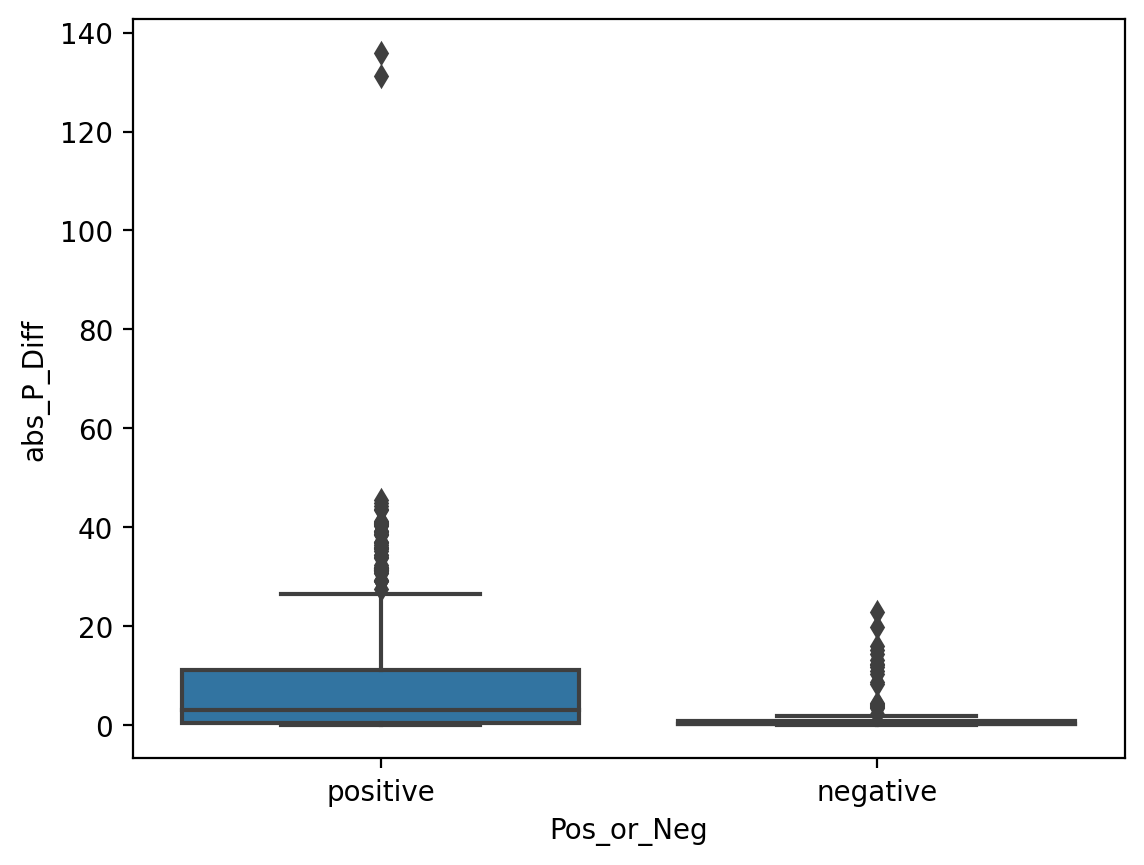

In [9]:
# Does order matter for CPU tests?

df_effect_cpu = calc_main(cpu_all, "exec_time")

# Calculate average percentage difference
df_effect_cpu["abs_P_Diff"] = df_effect_cpu["P_Diff"].apply(abs)
display(sum(df_effect_cpu["abs_P_Diff"].values)/ len(df_effect_cpu))

# Check drop/improvement in performance
df_effect_cpu["Pos_or_Neg"] = df_effect_cpu.apply(lambda row: p2posneg(row), axis=1)
ax = sns.boxplot(x = "Pos_or_Neg", y = "abs_P_Diff", data= df_effect_cpu)

df_effect_cpu_small_p = df_effect_cpu[df_effect_cpu["Kruskal_p"]<0.05]
neg =  df_effect_cpu_small_p[df_effect_cpu_small_p["Pos_or_Neg"]== "negative"]
pos = df_effect_cpu_small_p[df_effect_cpu_small_p["Pos_or_Neg"]== "positive"]
pos_neg = pd.DataFrame(columns=["num_seq_better_rand", "median", "90th percentile",
                                "num_rand_better_seq", "neg_median","neg_90th_percentile"])
pos_neg.loc[len(pos_neg)] = [len(pos), \
                             stat.median(pos["abs_P_Diff"].values),\
                             pos["abs_P_Diff"].quantile(0.9),\
                             len(neg),\
                             stat.median(neg["abs_P_Diff"].values),\
                             neg["abs_P_Diff"].quantile(0.9)]
display(pos_neg)

Based on the velues printed by the last two cells, we conclude in the paper: 

`Though they have similar absolute average ∆% values (8% for memory, and 7.3% for CPU), the details of their curves are quite different.` (in Section 5.1.3).

### Values for Table 2 in the paper

In [10]:
# Code below outputs the numbers mentioned in sections 5.1.1 and 5.1.2 in the paper and the breakdowns described in Table 2

alpha_default = 0.05

alpha_bc_cpu = alpha_default/len(df_effect_cpu)
print("Bonferroni-corrected threshold for CPU tests analysis:", alpha_bc_cpu)

alpha_bc_mem = alpha_default/len(df_effect_mem)
print("Bonferroni-corrected threshold for memory tests analysis:", alpha_bc_mem)

print("\nMemory: KW p < alpha_bc_cpu (counts; 1st row of Table 2):\n", (df_effect_mem["Kruskal_p"] < alpha_bc_mem).value_counts())

print("\nCPU: KW p < alpha_bc_cpu (counts; 2nd row of Table 2):\n", (df_effect_cpu["Kruskal_p"] < alpha_bc_cpu).value_counts())

# The code above prints the absolute number of the instances where p < alpha_bc; 
# the relative numbers (percentages) are trivial to get by dividing them by the total numbers printed below (which make the 3rd column of Table 2)

print("\nTotal number of memory tests:", len(df_effect_mem))
print("\nTotal number of CPU tests:", len(df_effect_cpu))

Bonferroni-corrected threshold for CPU tests analysis: 7.331378299120235e-05
Bonferroni-corrected threshold for memory tests analysis: 4.1736227045075125e-05

Memory: KW p < alpha_bc_cpu (counts; 1st row of Table 2):
 True     1042
False     156
Name: Kruskal_p, dtype: int64

CPU: KW p < alpha_bc_cpu (counts; 2nd row of Table 2):
 True     475
False    207
Name: Kruskal_p, dtype: int64

Total number of memory tests: 1198

Total number of CPU tests: 682


### Visualizations for the paper 

`Please note the figures shown below are almost identical to the figures included in the paper although the figures in the paper have some additional styling elements`

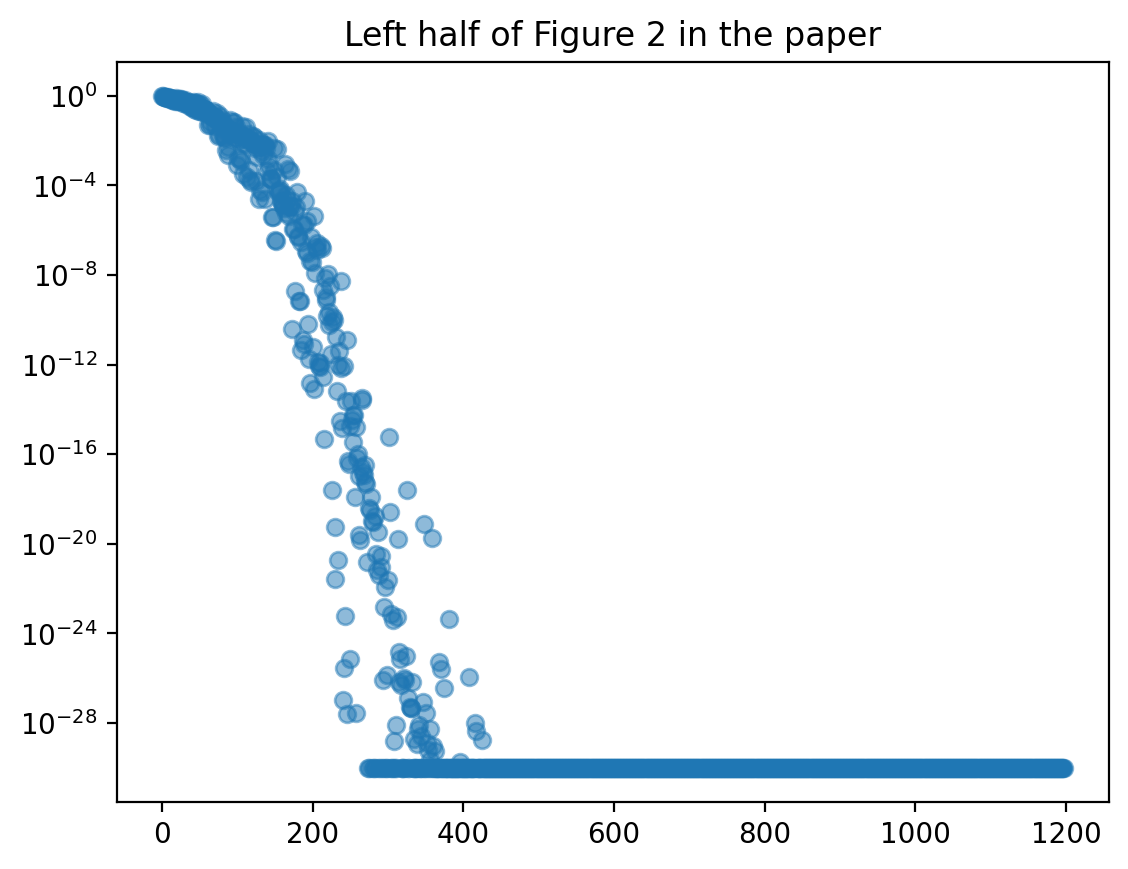

In [11]:
for_plotting = df_effect_mem[["effect_size_KW", "Kruskal_p"]].sort_values("effect_size_KW", ascending=True)
# Handle /very/ small nmbers for vis purposes
idx = for_plotting[for_plotting["Kruskal_p"] < 1e-30].index
for i in idx:
  for_plotting.at[i, "Kruskal_p"] = 1e-30
plt.plot(for_plotting["Kruskal_p"].to_list(), 'o', alpha = 0.5)
plt.yscale('log')
plt.title("Left half of Figure 2 in the paper");

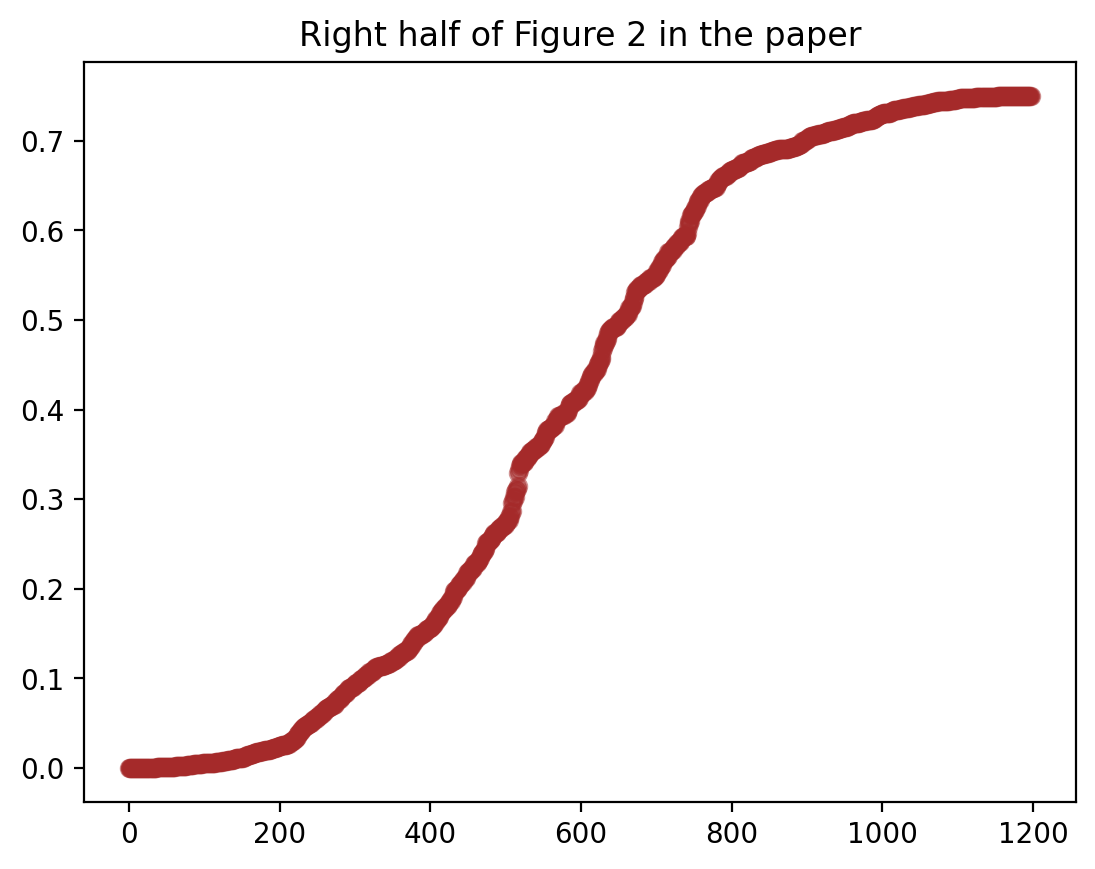

In [12]:
for_plotting = df_effect_mem[["effect_size_KW", "Kruskal_p"]].sort_values("effect_size_KW", ascending=True)
plt.plot(for_plotting["effect_size_KW"].to_list(), 'o', alpha = 0.5, color="brown")
plt.title("Right half of Figure 2 in the paper");

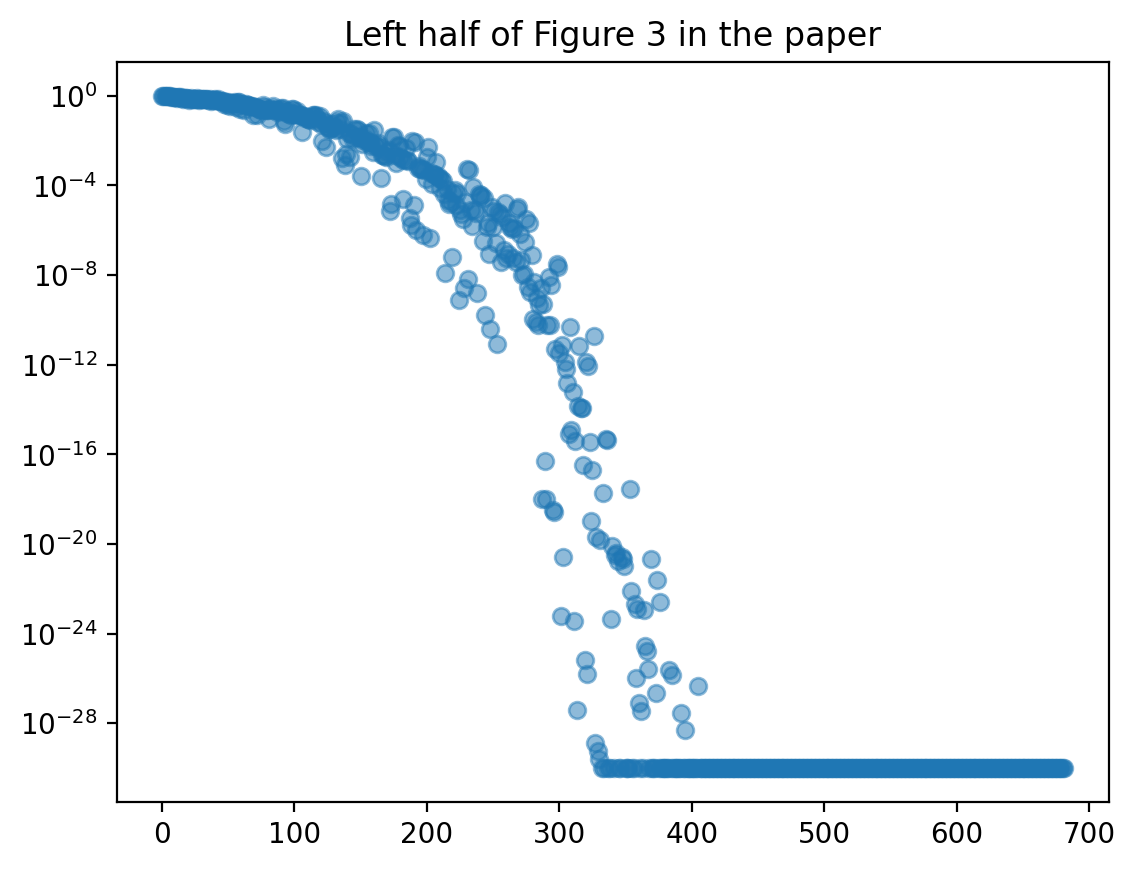

In [13]:
for_plotting = df_effect_cpu[["effect_size_KW", "Kruskal_p"]].sort_values("effect_size_KW", ascending=True)
# Handle /very/ small nmbers for vis purposes
idx = for_plotting[for_plotting["Kruskal_p"] < 1e-30].index
for i in idx:
  for_plotting.at[i, "Kruskal_p"] = 1e-30
plt.plot(for_plotting["Kruskal_p"].to_list(), 'o', alpha = 0.5)
plt.yscale('log')
plt.title("Left half of Figure 3 in the paper");

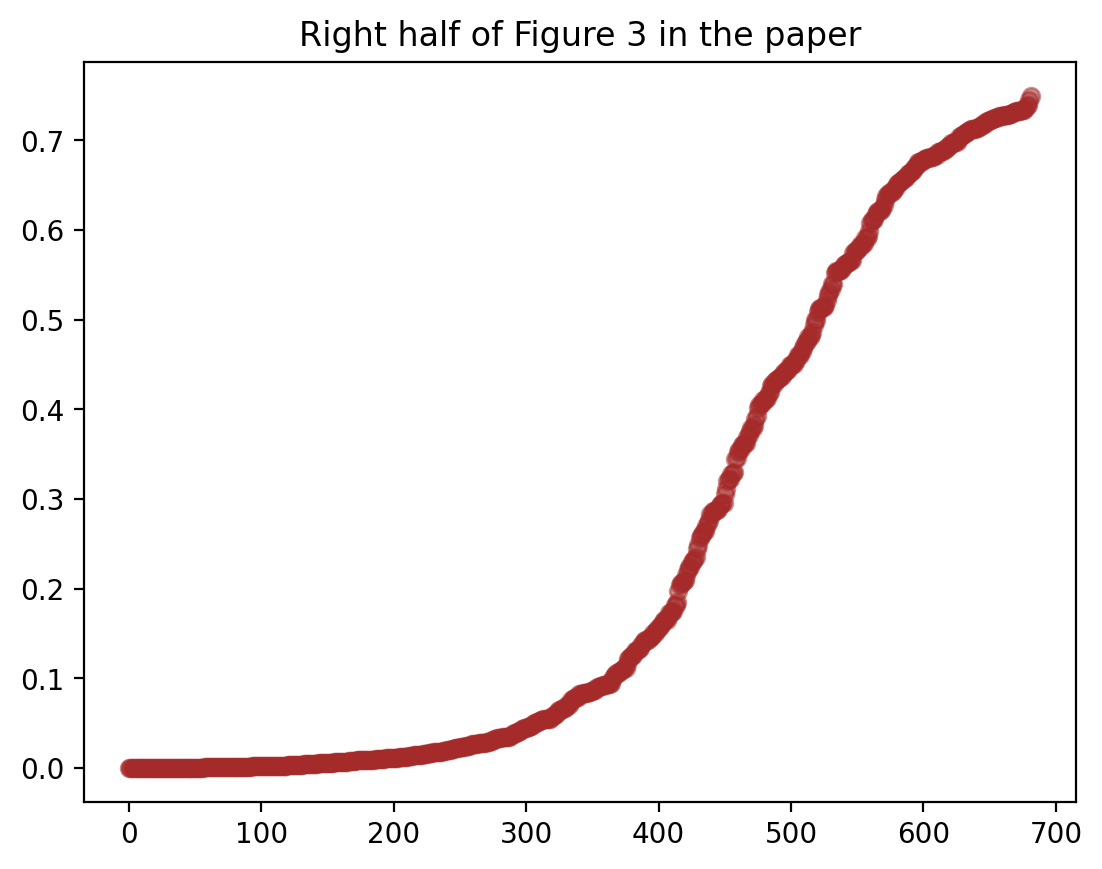

In [14]:
for_plotting = df_effect_cpu[["effect_size_KW", "Kruskal_p"]].sort_values("effect_size_KW", ascending=True)
plt.plot(for_plotting["effect_size_KW"].to_list(), 'o', alpha = 0.5, color="brown")
plt.title("Right half of Figure 3 in the paper");

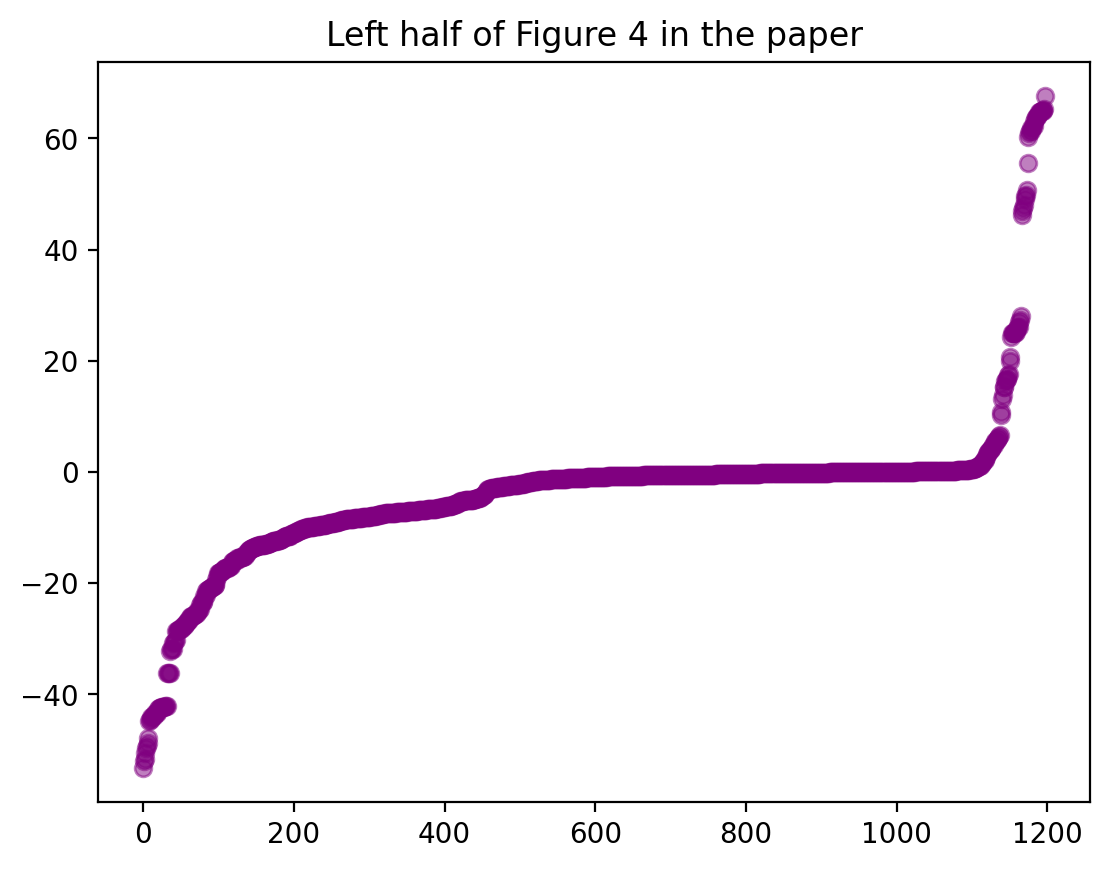

In [15]:
plt.plot(df_effect_mem["P_Diff"].sort_values().to_list(), 'o', color="purple", alpha=0.5)
plt.title("Left half of Figure 4 in the paper");

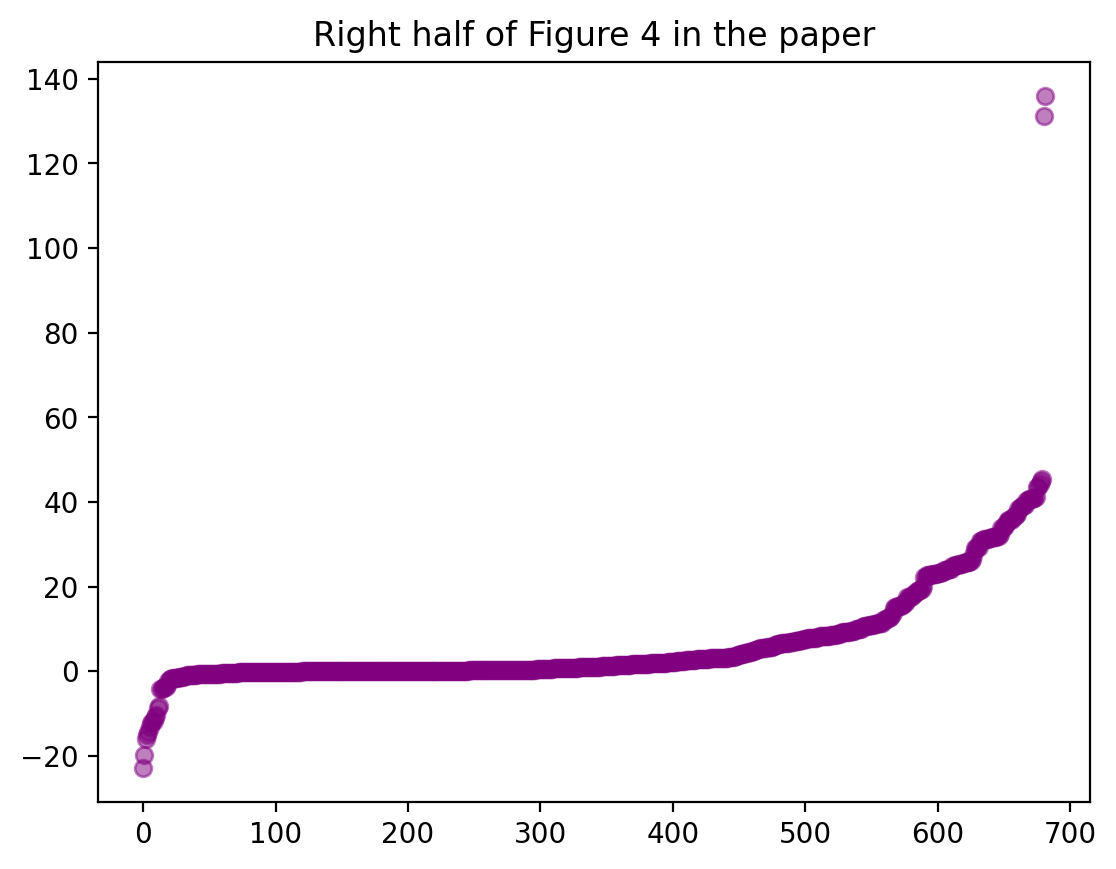

In [16]:
plt.plot(df_effect_cpu["P_Diff"].sort_values().to_list(), 'o', color="purple", alpha=0.5)
plt.title("Right half of Figure 4 in the paper");

### Analysis of confidence intervals

In [17]:
mem_ci_df = CI_compare_fixed_and_random(mem_all, "mean")
display(mem_ci_df)

,hw_type,testname,dvfs,socket_num,MT,random,pth_quantile,low,high
0,c220g1,add,no,0,0,0,10167.25,10139.50,10185.00
1,c220g1,add,no,0,0,1,10003.50,9974.53,10058.50
2,c220g1,add,no,1,0,0,10081.40,10043.80,10104.60
3,c220g1,add,no,1,0,1,10041.50,9997.55,10099.50
4,c220g1,add,yes,0,0,0,12720.70,12686.60,12760.60
...,...,...,...,...,...,...,...,...,...
2391,xl170,write_memory_sse,yes,0,0,1,8654.44,8650.27,8659.17
2392,xl170,write_memory_sse_omp,no,0,1,0,21306.70,21295.90,21320.60
2393,xl170,write_memory_sse_omp,no,0,1,1,21207.90,21185.60,21235.80
2394,xl170,write_memory_sse_omp,yes,0,1,0,21321.50,21307.40,21337.70


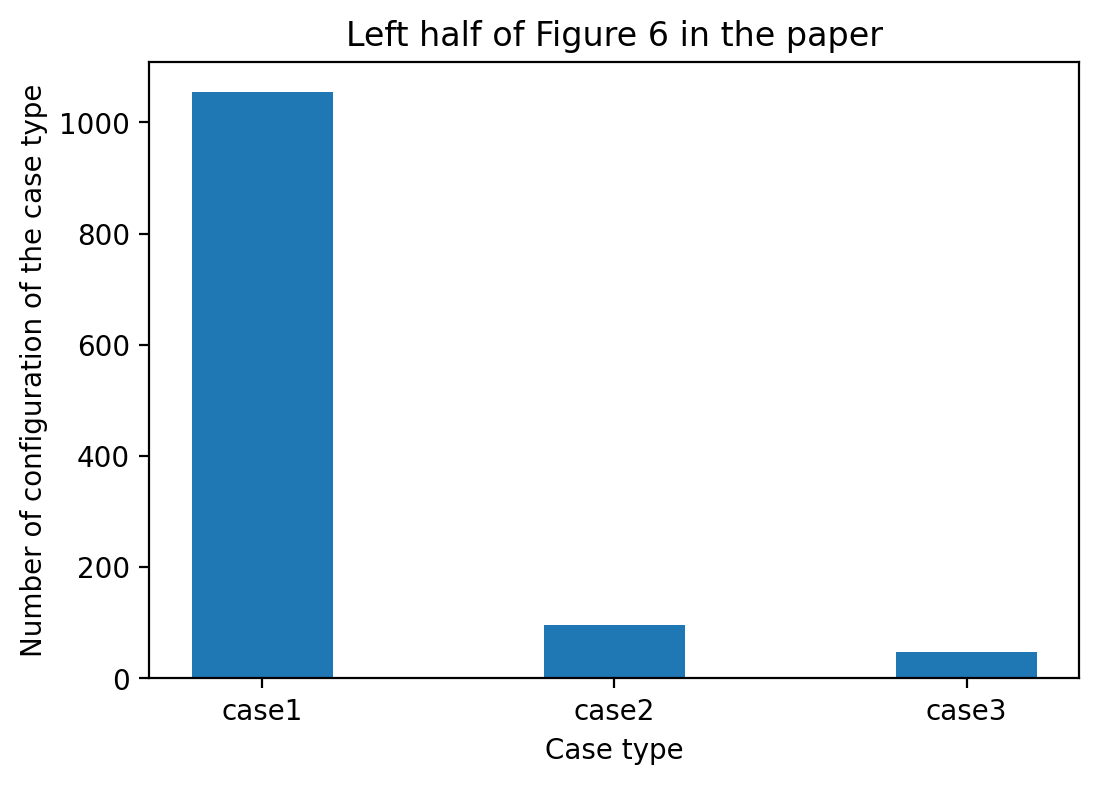

In [18]:
mem_ci = CI_count_cases(mem_ci_df)
counts = list(mem_ci["Case"].value_counts())
CI_plot_cases(counts)
plt.title("Left half of Figure 6 in the paper");

In [19]:
cpu_ci_df = CI_compare_fixed_and_random(cpu_all, "exec_time")
display(cpu_ci_df)

,hw_type,testname,dvfs,socket_num,MT,random,pth_quantile,low,high
0,c220g1,BT,no,0,0,0,2.6800,2.678,2.681
1,c220g1,BT,no,0,0,1,2.6830,2.683,2.684
2,c220g1,BT,no,0,1,0,8.2655,8.202,8.282
3,c220g1,BT,no,0,1,1,8.3120,8.309,8.316
4,c220g1,BT,no,1,0,0,2.6790,2.678,2.680
...,...,...,...,...,...,...,...,...,...
1359,xl170,UA,no,0,1,1,4.0350,4.033,4.036
1360,xl170,UA,yes,0,0,0,1.6580,1.657,1.659
1361,xl170,UA,yes,0,0,1,2.3020,2.301,2.303
1362,xl170,UA,yes,0,1,0,3.7510,3.749,3.752


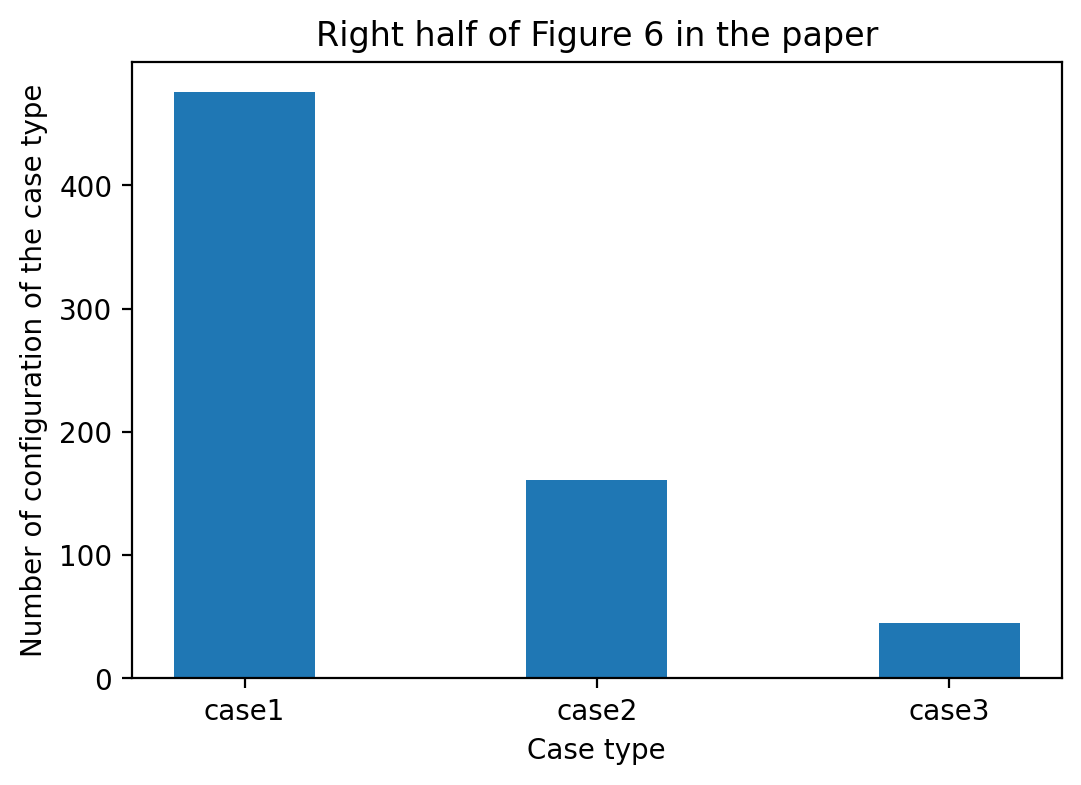

In [20]:
cpu_ci = CI_count_cases(cpu_ci_df)
counts = list(cpu_ci["Case"].value_counts())
CI_plot_cases(counts)
plt.title("Right half of Figure 6 in the paper");